## Arihant shashank
### arihant.shashank01@gmail.com
### +(91)-7337082594

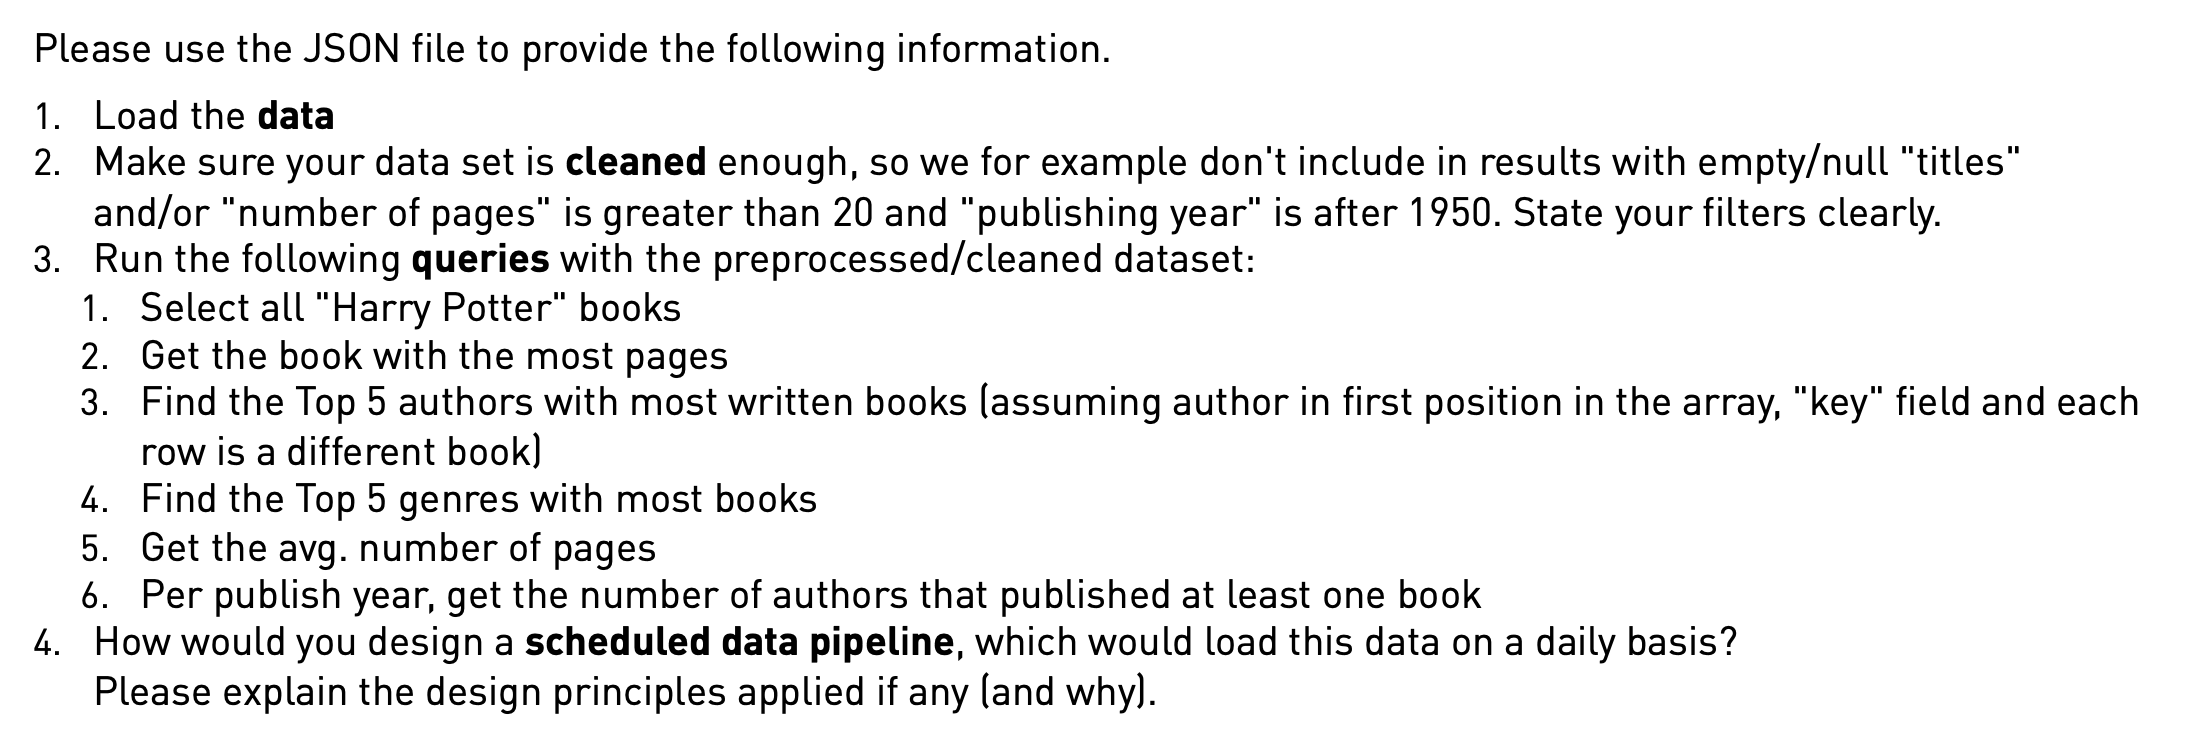

##### all necessary imports

In [1]:
import pandas as pd
import numpy as np
import pyspark
from pyspark.sql.functions import when
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf, log
from pyspark.sql.functions import col
import string
from pyspark.sql.types import StructType


#Create SparkSession
spark = SparkSession.builder \
                    .master("local[1]") \
                    .appName("SparkByExamples.com") \
                    .getOrCreate()

#### Load the data

In [2]:
# curl "https://s3-eu-west-1.amazonaws.com/csparkdata/ol_cdump.json" -O /Users/a0s0m24/Downloads/pyspark_code/ol_cdump.json
# Loading the data
from pyspark.sql.functions import array_contains


file_path ="./ol_cdump.json"
read_json_file =spark.read.json(file_path)


##### Make sure your data set is cleaned enough, so we for example don't include in results with empty/null "titles" and/or "number of pages" is greater than 20 and "publishing year" is after 1950. State your filters clearly.

In [3]:
filter1_numberPages= read_json_file.filter(read_json_file["number_of_pages"]>20)
# filter2=filter1.select(filter1["publish_date"]).distinct()
# filter2.show(100)
def date_splitter(df1):
    """
    it will take the column publish_date and do the required
    iterations to get the year part
    """
    years=0
    if df1 is None or df1=="":
        years=0
    else:    
        year=df1[-4:]
        if year.isdigit():
            years=int(year)
        else:
            years=0
    return years
date_splitter_udf = udf(lambda z: date_splitter(z)) 


filter2_year_1=filter1_numberPages.withColumn("year",date_splitter_udf(col("publish_date")))
filter2_year  = filter2_year_1.filter(filter2_year_1["year"]>1950)
filter2_year.filter(filter2_year["title"].isNull()).count()

0

##### Select all "Harry Potter" books

In [4]:
finding_harry_potter=filter2_year.filter(filter2_year["title"].like("%Harry Potter%"))
finding_harry_potter.select("title").show(100,False)

+----------------------------------------+
|title                                   |
+----------------------------------------+
|Harry Potter and the philosopher's stone|
|Harry Potter y la piedra filosofal      |
|The Science of Harry Potter             |
+----------------------------------------+



##### Get the book with the most pages

In [5]:
max_pages = filter2_year.agg({"number_of_pages": "max"}).collect()[0][0] 
# this will collect the max number of pages

In [6]:
filter2_year.filter(filter2_year.number_of_pages>=max_pages).select(filter2_year.title.alias("book name"),filter2_year.number_of_pages).show(10,False)

+-----------------------------+---------------+
|book name                    |number_of_pages|
+-----------------------------+---------------+
|Nihon shokuminchi kenchikuron|48418          |
+-----------------------------+---------------+



###### Find the Top 5 authors with most written books (assuming author in first position in the array, "key" field and each row is a different book)

In [43]:

authors=filter2_year.groupBy("authors").count()
top_authors=authors.orderBy(col("count").desc())
top_authors.show(5,False)


+-----------------------------------+-----+
|authors                            |count|
+-----------------------------------+-----+
|[{null, /authors/OL1224818A, null}]|236  |
|null                               |187  |
|[{null, /authors/OL4283462A, null}]|116  |
|[{null, /authors/OL785848A, null}] |106  |
|[{null, /authors/OL539875A, null}] |90   |
+-----------------------------------+-----+
only showing top 5 rows



##### 4. Find the Top 5 genres with most books

In [45]:
top_generes =filter2_year.groupBy("genres").count()
top_generes.orderBy(col("count").desc()).show(5,False)

+----------------------+-----+
|genres                |count|
+----------------------+-----+
|null                  |60943|
|[Fiction.]            |2825 |
|[Biography.]          |2038 |
|[Juvenile literature.]|1145 |
|[Exhibitions.]        |774  |
+----------------------+-----+
only showing top 5 rows



##### 5. Get the avg. number of pages

In [46]:
filter2_year.createOrReplaceTempView("df_final")

In [53]:
avg_pages= spark.sql("select round(sum(number_of_pages)/count(*),2) as avg_pages from df_final")

In [54]:
avg_pages.show()

+---------+
|avg_pages|
+---------+
|   232.05|
+---------+



#### 6. Per publish year, get the number of authors that published at least one book

In [60]:
spark.sql("select year,count(*) as number_of_authors from df_final group by year order by year").show()

+----+-----------------+
|year|number_of_authors|
+----+-----------------+
|1951|              676|
|1952|              633|
|1953|              623|
|1954|              667|
|1955|              612|
|1956|              664|
|1957|              741|
|1958|              790|
|1959|              880|
|1960|              964|
|1961|             1075|
|1962|             1130|
|1963|             1183|
|1964|             1270|
|1965|             1348|
|1966|             1299|
|1967|             1324|
|1968|             1164|
|1969|             1288|
|1970|             1230|
+----+-----------------+
only showing top 20 rows



#### How would you design a scheduled data pipeline, which would load this data on a daily basis? Please explain the design principles applied if any (and why).

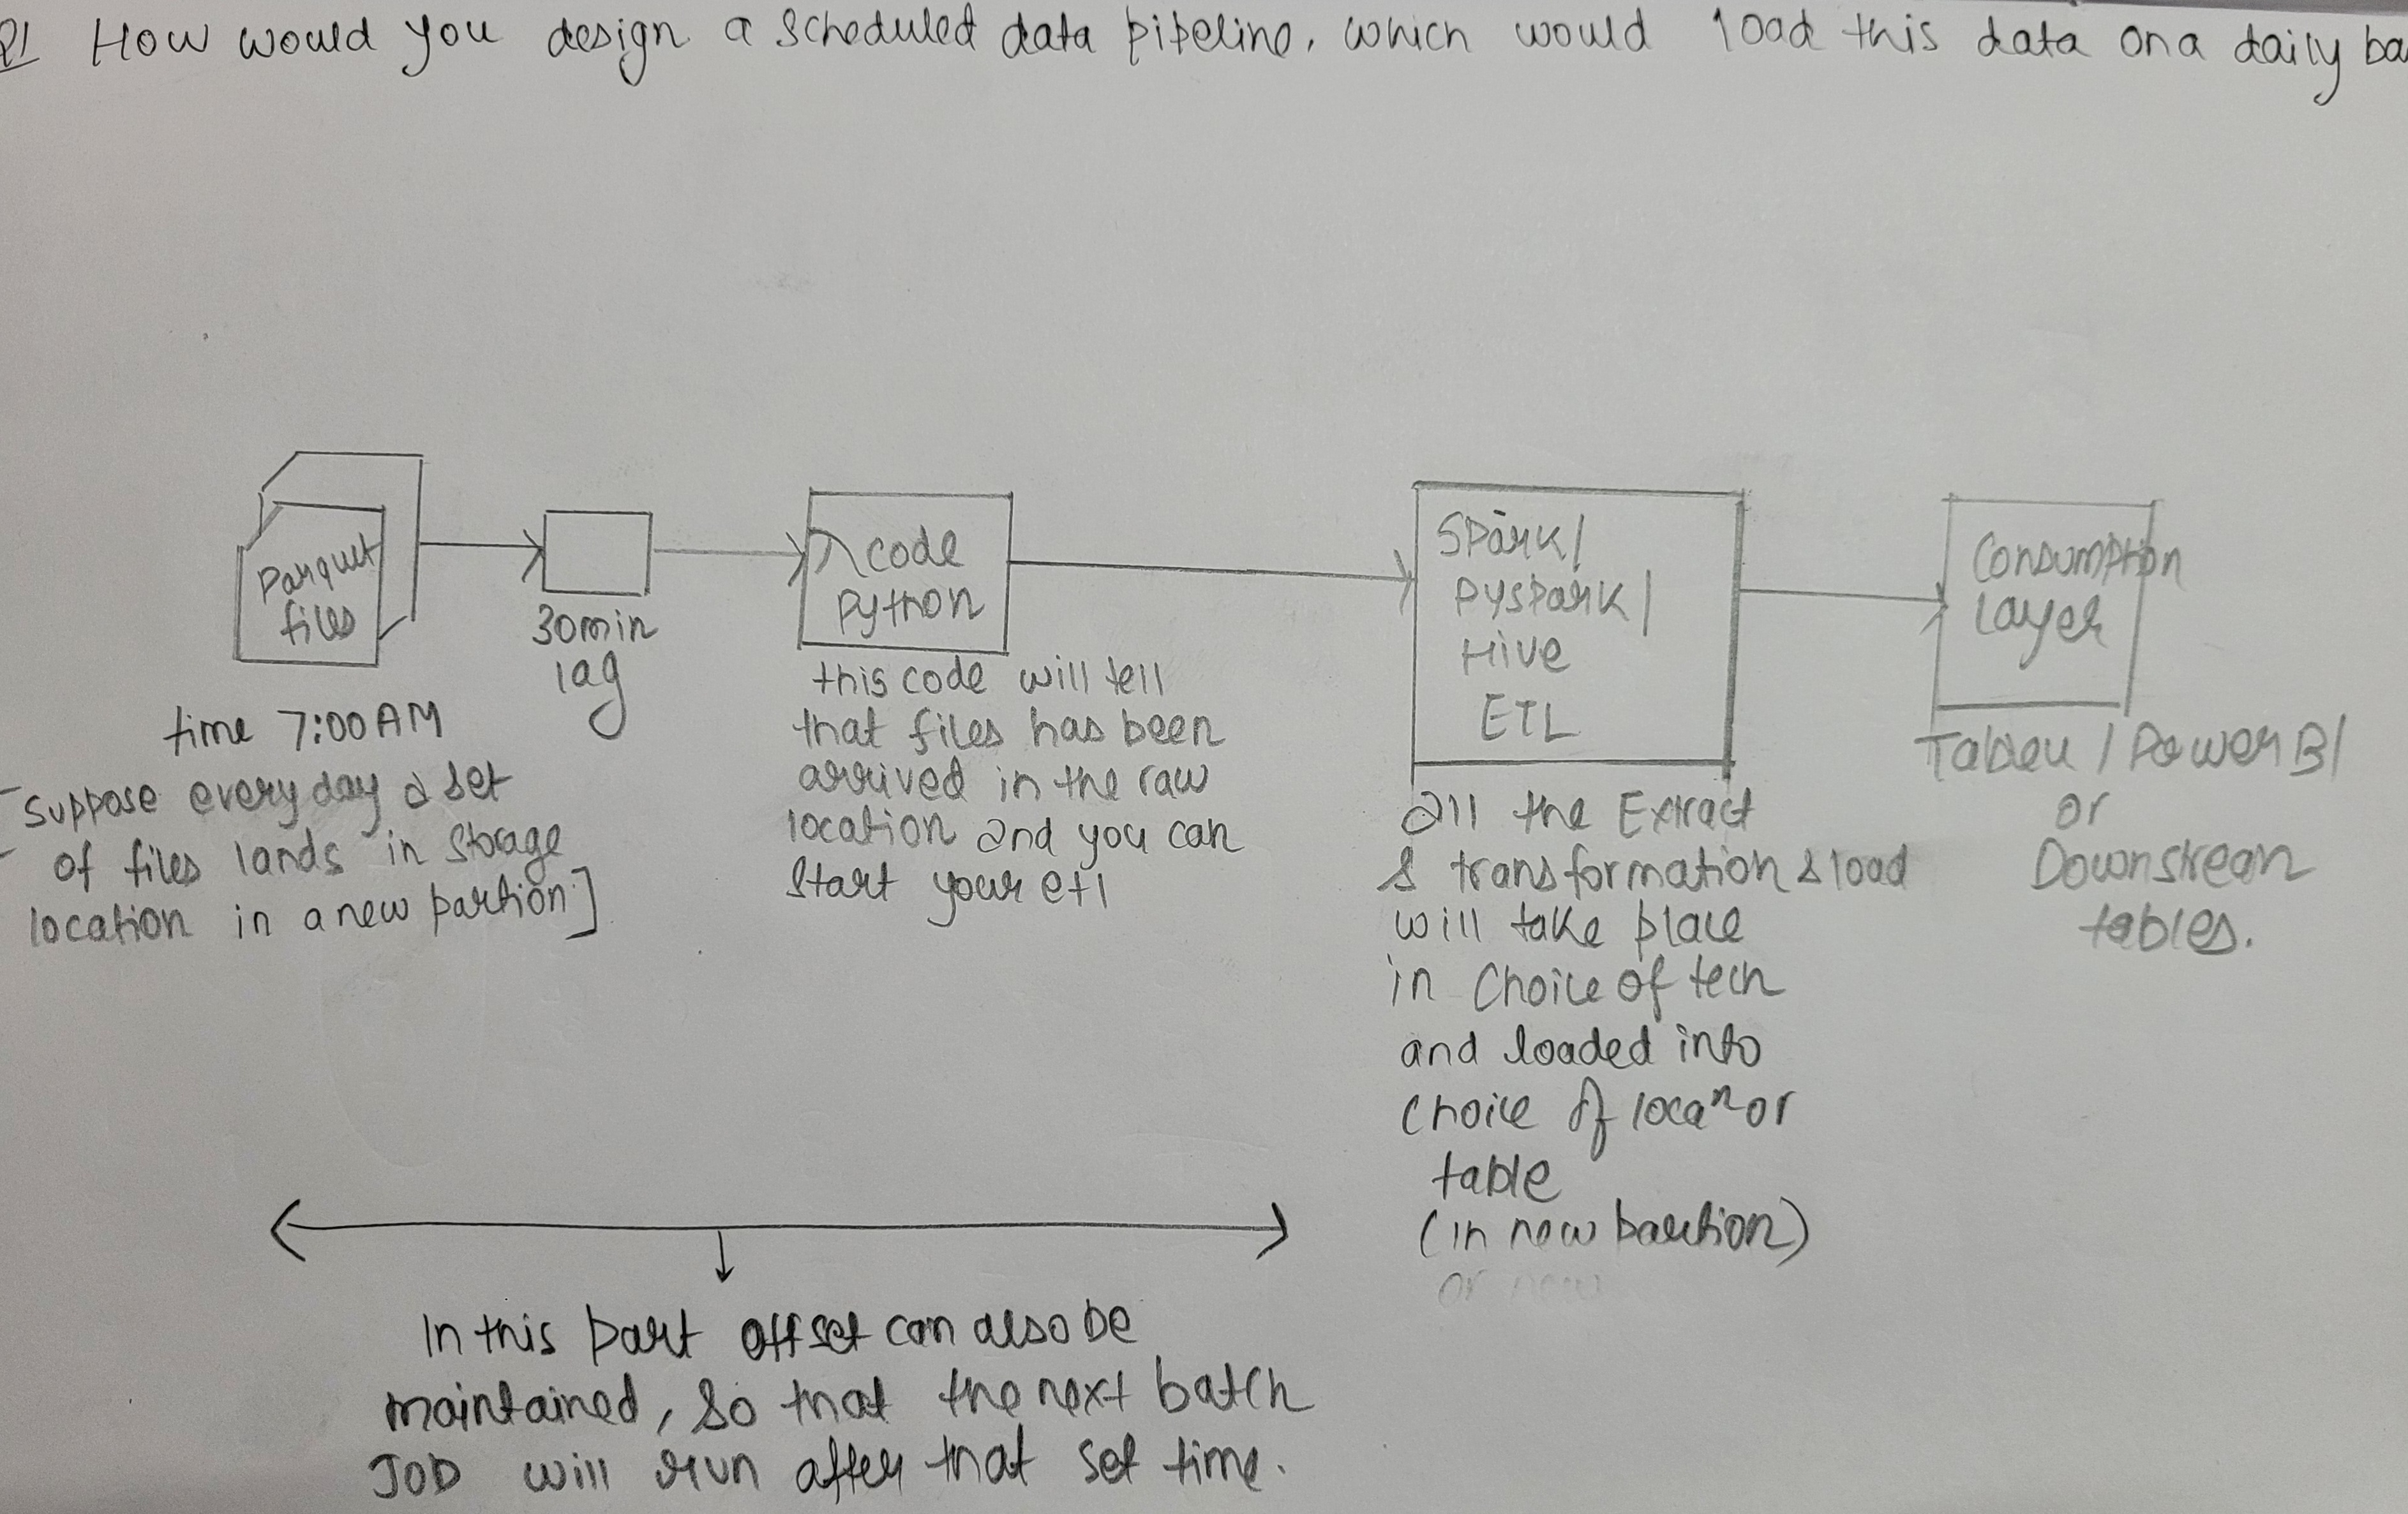